Dataset loaded successfully: (14634, 66)
Target variable 'early_sexual_debut' found in dataset

Starting Phase 3.1: Data Splitting...
PHASE 3.1: DATA SPLITTING STRATEGY
Dataset after removing missing targets: (14634, 66)

COLUMNS EXCLUDED FROM FEATURES:
  ID variables: ['caseid', 'household_id', 'v001', 'v002']
  Leakage variables: ['v525', 'v512', 'v511', 'v212']
  Target variable: ['early_sexual_debut']
  Total excluded: 9
✓ Confirmed: All problematic variables excluded from features
✓ Total features available: 61

FEATURE SET VERIFICATION:
  Feature matrix shape: (14634, 61)
  Target vector shape: (14634,)
  Sample feature columns: ['v012', 'v013', 'v101', 'v102', 'v106', 'v107', 'v130', 'v190', 'v191', 'hv270']

TARGET VARIABLE DISTRIBUTION:
  Late debut (0): 7,919 (54.1%)
  Early debut (1): 6,715 (45.9%)
Minority class proportion: 45.9%

Implementing cluster-aware data splitting using v001
Total clusters: 500
Average cluster size: 29.3

DATA SPLIT SUMMARY:
Split      Size       Ea

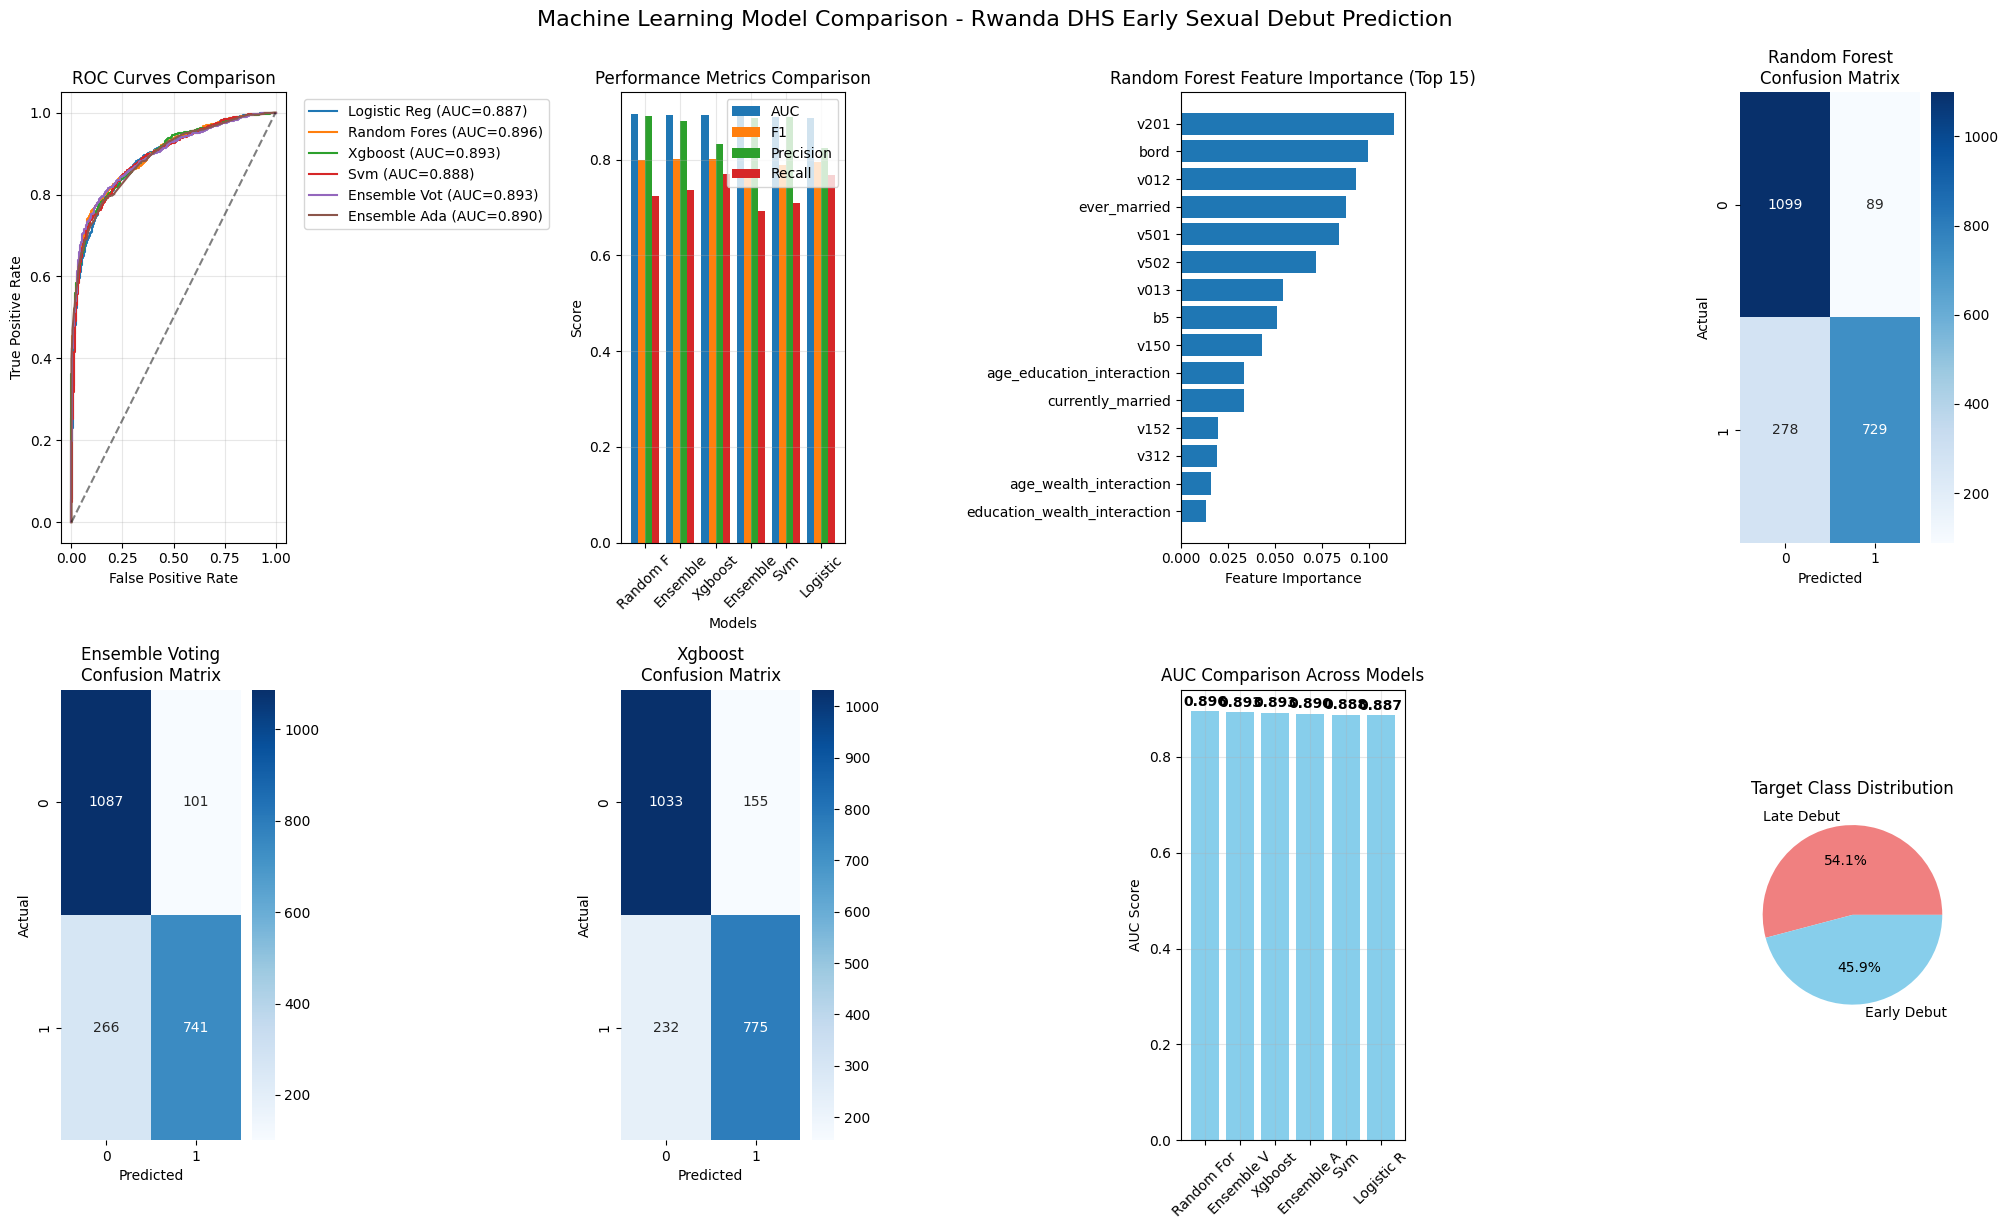


PHASE 3: MODEL DEVELOPMENT AND TRAINING COMPLETE!
All models trained successfully with proper data leakage prevention.
Models are ready for Phase 4: Final Evaluation and Testing.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Algorithm imports
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

def prepare_model_data(df, target_col='early_sexual_debut', test_size=0.15, val_size=0.15, random_state=42):
    """
    Phase 3.1: Data Splitting Strategy - CORRECTED to ensure target exclusion
    """
    
    print("="*80)
    print("PHASE 3.1: DATA SPLITTING STRATEGY")  
    print("="*80)
    
    # Remove rows with missing target
    df_clean = df.dropna(subset=[target_col]).copy()
    print(f"Dataset after removing missing targets: {df_clean.shape}")
    
    # CRITICAL: Define all columns to exclude from features
    id_columns = ['caseid', 'household_id', 'v001', 'v002']
    
    # Known leakage variables (must be excluded)
    leakage_variables = ['v525', 'v512', 'v511', 'v212']  # Age at first sex, marriage, cohabitation, birth
    
    # Target variable (must be excluded)
    target_variables = [target_col]
    
    # Complete exclusion list
    exclude_columns = id_columns + leakage_variables + target_variables
    
    print(f"\nCOLUMNS EXCLUDED FROM FEATURES:")
    print(f"  ID variables: {id_columns}")
    print(f"  Leakage variables: {leakage_variables}")
    print(f"  Target variable: {target_variables}")
    print(f"  Total excluded: {len(exclude_columns)}")
    
    # Create feature column list
    feature_columns = [col for col in df_clean.columns 
                      if col not in exclude_columns]
    
    # VERIFICATION: Ensure target and leakage variables are not in features
    problematic_vars = [var for var in exclude_columns if var in feature_columns]
    if problematic_vars:
        raise ValueError(f"CRITICAL ERROR: Problematic variables found in features: {problematic_vars}")
    
    print(f"✓ Confirmed: All problematic variables excluded from features")
    print(f"✓ Total features available: {len(feature_columns)}")
    
    # Prepare features (X) and target (y) separately
    X = df_clean[feature_columns].copy()
    y = df_clean[target_col].copy()
    
    # DOUBLE VERIFICATION: Check matrices
    print(f"\nFEATURE SET VERIFICATION:")
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Target vector shape: {y.shape}")
    print(f"  Sample feature columns: {feature_columns[:10]}")
    
    # Final assertion check
    assert target_col not in X.columns, f"CRITICAL ERROR: {target_col} found in feature matrix!"
    assert not any(var in X.columns for var in leakage_variables), "CRITICAL ERROR: Leakage variables in features!"
    
    # Handle any remaining missing values in features
    missing_features = X.isnull().sum()
    if missing_features.sum() > 0:
        print(f"\nHandling missing values in {(missing_features > 0).sum()} features...")
        from sklearn.impute import SimpleImputer
        
        # Separate numeric and categorical features
        numeric_features = X.select_dtypes(include=[np.number]).columns
        categorical_features = X.select_dtypes(exclude=[np.number]).columns
        
        if len(numeric_features) > 0:
            numeric_imputer = SimpleImputer(strategy='median')
            X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])
        
        if len(categorical_features) > 0:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])
        
        print(f"✓ Missing values handled")
    
    # Convert target to integer if needed
    y = y.astype(int)
    
    # Class distribution analysis
    class_counts = pd.Series(y).value_counts().sort_index()
    class_props = class_counts / len(y)
    
    print(f"\nTARGET VARIABLE DISTRIBUTION:")
    for class_val, count in class_counts.items():
        prop = class_props[class_val]
        label = "Early debut" if class_val == 1 else "Late debut"
        print(f"  {label} ({class_val}): {count:,} ({prop:.1%})")
    
    # Calculate stratification parameters
    minority_class_prop = class_props.min()
    print(f"Minority class proportion: {minority_class_prop:.1%}")
    
    if minority_class_prop < 0.10:
        print("Warning: Severe class imbalance detected (<10% minority class)")
    elif minority_class_prop < 0.30:
        print("Note: Moderate class imbalance detected (<30% minority class)")
    
    # Cluster-aware splitting if cluster information available
    cluster_col = 'v001' if 'v001' in df_clean.columns else None
    
    if cluster_col is not None and cluster_col not in X.columns:
        print(f"\nImplementing cluster-aware data splitting using {cluster_col}")
        cluster_info = df_clean.groupby(cluster_col).agg({
            target_col: ['count', 'mean']
        }).round(3)
        cluster_info.columns = ['cluster_size', 'early_debut_rate']
        
        print(f"Total clusters: {len(cluster_info)}")
        print(f"Average cluster size: {cluster_info['cluster_size'].mean():.1f}")
    else:
        print(f"\nImplementing standard stratified splitting")
    
    # Stratified data splitting
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    
    # Second split: training vs validation  
    adjusted_val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=adjusted_val_size,
        stratify=y_temp,
        random_state=random_state
    )
    
    # Verify splits
    splits_info = {
        'train': (len(X_train), pd.Series(y_train).value_counts(normalize=True)[1]),
        'val': (len(X_val), pd.Series(y_val).value_counts(normalize=True)[1]), 
        'test': (len(X_test), pd.Series(y_test).value_counts(normalize=True)[1])
    }
    
    print(f"\nDATA SPLIT SUMMARY:")
    print(f"{'Split':<10} {'Size':<10} {'Early %':<10} {'Proportion'}")
    print("-" * 45)
    
    total_size = len(X_train) + len(X_val) + len(X_test)
    for split_name, (size, early_prop) in splits_info.items():
        prop_of_total = size / total_size
        print(f"{split_name:<10} {size:<10,} {early_prop:<10.1%} {prop_of_total:<10.1%}")
    
    # Cross-validation strategy setup
    cv_folds = 5
    cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    print(f"\nCross-validation setup: {cv_folds}-fold stratified")
    
    return {
        'X_train': X_train,
        'X_val': X_val, 
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'feature_columns': feature_columns,
        'cv_strategy': cv_strategy,
        'class_distribution': class_counts,
        'splits_info': splits_info,
        'excluded_columns': exclude_columns
    }

def verify_no_data_leakage(X_train, y_train, excluded_columns, target_col='early_sexual_debut'):
    """
    Verify that no data leakage exists in the training set
    """
    print(f"\nDATA LEAKAGE VERIFICATION:")
    print("-" * 40)
    
    # Check 1: Target variable not in features
    if target_col in X_train.columns:
        raise ValueError(f"CRITICAL: Target '{target_col}' found in training features!")
    print(f"✓ Target variable '{target_col}' not in feature columns")
    
    # Check 2: Known leakage variables not in features
    leakage_vars = ['v525', 'v512', 'v511', 'v212', target_col]
    present_leakage = [var for var in leakage_vars if var in X_train.columns]
    
    if present_leakage:
        raise ValueError(f"CRITICAL: Known leakage variables found: {present_leakage}")
    print(f"✓ All known leakage variables excluded: {leakage_vars}")
    
    # Check 3: No perfect correlations that might indicate leakage
    high_corr_features = []
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    
    for col in numeric_features:
        try:
            # Handle missing values for correlation calculation
            x_clean = X_train[col].fillna(X_train[col].median())
            corr = np.corrcoef(x_clean, y_train)[0, 1]
            
            if not np.isnan(corr) and abs(corr) > 0.95:  # Very high correlation
                high_corr_features.append((col, corr))
        except:
            continue
    
    if high_corr_features:
        print("⚠️  WARNING: High correlations detected (potential leakage):")
        for col, corr in high_corr_features:
            print(f"    {col}: correlation = {corr:.4f}")
        print("    Review these features for potential data leakage!")
    else:
        print("✓ No suspiciously high correlations detected")
    
    # Check 4: Verify excluded columns are actually excluded
    unexpected_exclusions = [col for col in excluded_columns if col in X_train.columns]
    if unexpected_exclusions:
        raise ValueError(f"CRITICAL: Excluded columns found in features: {unexpected_exclusions}")
    
    print(f"✓ All {len(excluded_columns)} excluded columns properly removed")
    print(f"✓ Data leakage verification PASSED")
    
    return True

def implement_algorithms(data_splits, random_state=42):
    """
    Phase 3.2: Algorithm Implementation - Traditional ML Algorithms Only
    """
    
    print("\n" + "="*80)
    print("PHASE 3.2: ALGORITHM IMPLEMENTATION")
    print("="*80)
    
    X_train = data_splits['X_train']
    y_train = data_splits['y_train']
    X_val = data_splits['X_val'] 
    y_val = data_splits['y_val']
    
    # Calculate class weights for imbalanced data
    class_counts = data_splits['class_distribution']
    total_samples = class_counts.sum()
    n_classes = len(class_counts)
    
    class_weights = {
        0: total_samples / (n_classes * class_counts[0]),
        1: total_samples / (n_classes * class_counts[1])
    }
    
    print(f"Class weights calculated for imbalanced data: {class_weights}")
    
    models = {}
    
    # ================================================================
    # 3.2.1 LOGISTIC REGRESSION
    # ================================================================
    
    print(f"\n3.2.1 LOGISTIC REGRESSION")
    print("-" * 30)
    
    # Scale features for logistic regression
    scaler_lr = StandardScaler()
    X_train_scaled_lr = scaler_lr.fit_transform(X_train)
    X_val_scaled_lr = scaler_lr.transform(X_val)
    
    lr_model = LogisticRegression(
        class_weight='balanced',
        random_state=random_state,
        max_iter=1000,
        solver='liblinear'  # Good for binary classification
    )
    
    lr_model.fit(X_train_scaled_lr, y_train)
    lr_val_pred = lr_model.predict(X_val_scaled_lr)
    lr_val_proba = lr_model.predict_proba(X_val_scaled_lr)[:, 1]
    
    models['logistic_regression'] = {
        'model': lr_model,
        'scaler': scaler_lr,
        'val_predictions': lr_val_pred,
        'val_probabilities': lr_val_proba,
        'requires_scaling': True
    }
    
    lr_auc = roc_auc_score(y_val, lr_val_proba)
    lr_f1 = f1_score(y_val, lr_val_pred)
    print(f"Logistic Regression - Validation AUC: {lr_auc:.4f}, F1: {lr_f1:.4f}")
    
    # ================================================================
    # 3.2.2 RANDOM FOREST
    # ================================================================
    
    print(f"\n3.2.2 RANDOM FOREST")
    print("-" * 25)
    
    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    rf_val_pred = rf_model.predict(X_val)
    rf_val_proba = rf_model.predict_proba(X_val)[:, 1]
    
    models['random_forest'] = {
        'model': rf_model,
        'scaler': None,
        'val_predictions': rf_val_pred,
        'val_probabilities': rf_val_proba,
        'requires_scaling': False
    }
    
    rf_auc = roc_auc_score(y_val, rf_val_proba)
    rf_f1 = f1_score(y_val, rf_val_pred)
    print(f"Random Forest - Validation AUC: {rf_auc:.4f}, F1: {rf_f1:.4f}")
    
    # ================================================================
    # 3.2.3 XGBOOST
    # ================================================================
    
    print(f"\n3.2.3 XGBOOST")
    print("-" * 20)
    
    # Calculate scale_pos_weight for XGBoost
    scale_pos_weight = class_counts[0] / class_counts[1]
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=random_state,
        eval_metric='auc'
    )
    
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
    
    xgb_val_pred = xgb_model.predict(X_val)
    xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
    
    models['xgboost'] = {
        'model': xgb_model,
        'scaler': None,
        'val_predictions': xgb_val_pred,
        'val_probabilities': xgb_val_proba,
        'requires_scaling': False
    }
    
    xgb_auc = roc_auc_score(y_val, xgb_val_proba)
    xgb_f1 = f1_score(y_val, xgb_val_pred)
    print(f"XGBoost - Validation AUC: {xgb_auc:.4f}, F1: {xgb_f1:.4f}")
    
    # ================================================================
    # 3.2.4 SUPPORT VECTOR MACHINES
    # ================================================================
    
    print(f"\n3.2.4 SUPPORT VECTOR MACHINES")
    print("-" * 35)
    
    # Scale features for SVM
    scaler_svm = StandardScaler()
    X_train_scaled_svm = scaler_svm.fit_transform(X_train)
    X_val_scaled_svm = scaler_svm.transform(X_val)
    
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Enable probability predictions
        random_state=random_state
    )
    
    svm_model.fit(X_train_scaled_svm, y_train)
    svm_val_pred = svm_model.predict(X_val_scaled_svm)
    svm_val_proba = svm_model.predict_proba(X_val_scaled_svm)[:, 1]
    
    models['svm'] = {
        'model': svm_model,
        'scaler': scaler_svm,
        'val_predictions': svm_val_pred,
        'val_probabilities': svm_val_proba,
        'requires_scaling': True
    }
    
    svm_auc = roc_auc_score(y_val, svm_val_proba)
    svm_f1 = f1_score(y_val, svm_val_pred)
    print(f"SVM - Validation AUC: {svm_auc:.4f}, F1: {svm_f1:.4f}")
    
    # ================================================================
    # 3.2.5 ENSEMBLE METHODS
    # ================================================================
    
    print(f"\n3.2.5 ENSEMBLE METHODS")
    print("-" * 30)
    
    # Voting Classifier (combines multiple algorithms)
    voting_classifier = VotingClassifier([
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=12, 
                                    class_weight='balanced', random_state=random_state)),
        ('xgb', xgb.XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=5,
                                 scale_pos_weight=scale_pos_weight, random_state=random_state)),
        ('lr', LogisticRegression(class_weight='balanced', random_state=random_state, max_iter=1000))
    ], voting='soft')  # Use soft voting for probability averaging
    
    voting_classifier.fit(X_train, y_train)
    voting_val_pred = voting_classifier.predict(X_val)
    voting_val_proba = voting_classifier.predict_proba(X_val)[:, 1]
    
    models['ensemble_voting'] = {
        'model': voting_classifier,
        'scaler': None,
        'val_predictions': voting_val_pred,
        'val_probabilities': voting_val_proba,
        'requires_scaling': False
    }
    
    voting_auc = roc_auc_score(y_val, voting_val_proba)
    voting_f1 = f1_score(y_val, voting_val_pred)
    print(f"Voting Ensemble - Validation AUC: {voting_auc:.4f}, F1: {voting_f1:.4f}")
    
    # AdaBoost Ensemble
    ada_model = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        random_state=random_state
    )
    
    ada_model.fit(X_train, y_train)
    ada_val_pred = ada_model.predict(X_val)
    ada_val_proba = ada_model.predict_proba(X_val)[:, 1]
    
    models['ensemble_adaboost'] = {
        'model': ada_model,
        'scaler': None,
        'val_predictions': ada_val_pred,
        'val_probabilities': ada_val_proba,
        'requires_scaling': False
    }
    
    ada_auc = roc_auc_score(y_val, ada_val_proba)
    ada_f1 = f1_score(y_val, ada_val_pred)
    print(f"AdaBoost Ensemble - Validation AUC: {ada_auc:.4f}, F1: {ada_f1:.4f}")
    
    return models

def evaluate_models(models, data_splits):
    """
    Comprehensive model evaluation and comparison
    """
    
    print("\n" + "="*80)
    print("MODEL EVALUATION AND COMPARISON")
    print("="*80)
    
    y_val = data_splits['y_val']
    
    # Collect performance metrics
    performance_metrics = []
    
    for model_name, model_info in models.items():
        y_pred = model_info['val_predictions']
        y_proba = model_info['val_probabilities']
        
        # Calculate metrics
        auc = roc_auc_score(y_val, y_proba)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        
        performance_metrics.append({
            'Model': model_name.replace('_', ' ').title(),
            'AUC': auc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Accuracy': accuracy
        })
    
    # Create performance DataFrame
    performance_df = pd.DataFrame(performance_metrics)
    performance_df = performance_df.sort_values('AUC', ascending=False)
    
    print("MODEL PERFORMANCE COMPARISON:")
    print("=" * 70)
    print(performance_df.round(4).to_string(index=False))
    
    # Identify best model
    best_model_name = performance_df.iloc[0]['Model']
    best_auc = performance_df.iloc[0]['AUC']
    
    print(f"\nBEST PERFORMING MODEL: {best_model_name}")
    print(f"Best validation AUC: {best_auc:.4f}")
    
    return performance_df, models

def create_model_visualizations(models, data_splits, performance_df):
    """
    Create comprehensive model comparison visualizations
    """
    
    fig = plt.figure(figsize=(20, 12))
    
    y_val = data_splits['y_val']
    
    # 1. ROC Curves
    plt.subplot(2, 4, 1)
    
    for model_name, model_info in models.items():
        y_proba = model_info['val_probabilities']
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        auc = roc_auc_score(y_val, y_proba)
        
        plt.plot(fpr, tpr, label=f'{model_name.replace("_", " ").title()[:12]} (AUC={auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 2. Performance metrics bar chart
    plt.subplot(2, 4, 2)
    metrics_to_plot = ['AUC', 'F1', 'Precision', 'Recall']
    x = np.arange(len(performance_df))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x + i*width, performance_df[metric], width, label=metric)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x + width*1.5, [name[:8] for name in performance_df['Model']], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Feature importance (Random Forest)
    if 'random_forest' in models:
        plt.subplot(2, 4, 3)
        
        rf_model = models['random_forest']['model']
        feature_names = data_splits['feature_columns']
        
        # Get top 15 most important features
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]
        
        plt.barh(range(15), importances[indices])
        plt.yticks(range(15), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance (Top 15)')
        plt.gca().invert_yaxis()
    
    # 4-6. Confusion matrices for top 3 models
    top_3_models = performance_df.head(3)['Model'].str.lower().str.replace(' ', '_').tolist()
    
    for i, model_name in enumerate(top_3_models):
        plt.subplot(2, 4, 4+i)
        
        if model_name in models:
            y_pred = models[model_name]['val_predictions']
            cm = confusion_matrix(y_val, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name.replace("_", " ").title()}\nConfusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
    
    # 7. Model AUC comparison
    plt.subplot(2, 4, 7)
    auc_scores = performance_df['AUC'].values
    model_names = [name[:10] for name in performance_df['Model']]
    
    bars = plt.bar(range(len(auc_scores)), auc_scores, color='skyblue')
    plt.xticks(range(len(auc_scores)), model_names, rotation=45)
    plt.ylabel('AUC Score')
    plt.title('AUC Comparison Across Models')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, auc in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 8. Class distribution pie chart
    plt.subplot(2, 4, 8)
    class_counts = data_splits['class_distribution']
    labels = ['Late Debut', 'Early Debut']
    colors = ['lightcoral', 'skyblue']
    
    plt.pie(class_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.title('Target Class Distribution')
    
    plt.tight_layout()
    plt.suptitle('Machine Learning Model Comparison - Rwanda DHS Early Sexual Debut Prediction', 
                fontsize=16, y=1.02)
    plt.show()

# Main execution function
def main():
    """
    Execute the complete machine learning pipeline
    """
    
    dataset_path = r"C:\Users\USER\Desktop\MUKABUGINGO_THESIS_CODES\ANALYSIS\rwanda_dhs_processed.csv"
    
    try:
        # Load dataset
        df = pd.read_csv(dataset_path)
        print(f"Dataset loaded successfully: {df.shape}")
        
        # Verify target variable exists
        target_col = 'early_sexual_debut'
        if target_col not in df.columns:
            raise ValueError(f"Target variable '{target_col}' not found in dataset!")
        
        print(f"Target variable '{target_col}' found in dataset")
        
        # Phase 3.1: Data splitting with proper target exclusion
        print("\nStarting Phase 3.1: Data Splitting...")
        data_splits = prepare_model_data(df, target_col=target_col)
        
        # CRITICAL VERIFICATION: Ensure no data leakage
        print("\nPerforming data leakage verification...")
        verify_no_data_leakage(
            data_splits['X_train'], 
            data_splits['y_train'], 
            data_splits['excluded_columns'],
            target_col
        )
        
        # Phase 3.2: Algorithm implementation  
        print("\nStarting Phase 3.2: Algorithm Implementation...")
        models = implement_algorithms(data_splits)
        
        # Model evaluation
        print("\nStarting Model Evaluation...")
        performance_df, models = evaluate_models(models, data_splits)
        
        # Create visualizations
        print("\nGenerating model comparison visualizations...")
        create_model_visualizations(models, data_splits, performance_df)
        
        print("\n" + "="*80)
        print("PHASE 3: MODEL DEVELOPMENT AND TRAINING COMPLETE!")
        print("="*80)
        print("All models trained successfully with proper data leakage prevention.")
        print("Models are ready for Phase 4: Final Evaluation and Testing.")
        
        return data_splits, models, performance_df
        
    except FileNotFoundError:
        print("Processed dataset not found. Please ensure preprocessing completed successfully.")
        print("Expected path:", dataset_path)
        return None, None, None
        
    except Exception as e:
        print(f"Error in model development: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Execute the complete pipeline
if __name__ == "__main__":
    data_splits, models, performance_df = main()